In [1]:
!python -m pip list

Package                       Version
----------------------------- ----------------------
absl-py                       0.7.1
antialiased-cnns              0.3
apturl                        0.5.2
astor                         0.8.0
backcall                      0.2.0
beautifulsoup4                4.4.1
blinker                       1.3
Brlapi                        0.6.4
catfish                       1.4.2
chardet                       2.3.0
checkbox-support              0.22
command-not-found             0.3
cryptography                  1.2.3
cycler                        0.10.0
dataclasses                   0.7
decorator                     4.4.0
defer                         1.0.6
efficientnet                  1.0.0b3
feedparser                    5.1.3
future                        0.18.2
gast                          0.2.2
google-pasta                  0.1.7
grpcio                        1.22.0
guacamole                     0.9.2
h5py                          2.9.0
httplib2     

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from natsort import natsorted
from sklearn import preprocessing
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

# import antialiased_cnns

import time
import os
import PIL.Image as Image
# from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
TITAN Xp


## Dataloader

In [3]:
# Custom dataSet
class CustomDataSet(torch.utils.data.Dataset):
    def __init__(self, main_dir, labels, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)
        self.lbls = labels

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert('RGB')
        tensor_image = self.transform(image)
        label = self.lbls[idx]
        return tensor_image, label

train_folder_path = r'data/train'
test_folder_path = r'data/test'

# encode string label to tensor
train_label = pd.read_csv('training_labels.csv').sort_values(by=['id'])
lbls = train_label['label'].values.tolist()
le = preprocessing.LabelEncoder()
targets = le.fit_transform(lbls)
targets = torch.as_tensor(targets)

# traning data transforms: resize to 400x400, flip, rotation, normalize
train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5,), (0.5,))])

dataset = CustomDataSet(train_folder_path, targets, transform=train_tfms)
# split training set and validation set
# trainset, validset = torch.utils.data.random_split(dataset, [10000, 1185])

# train loader
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=0)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

# validation loader
# validloader = torch.utils.data.DataLoader(validset, batch_size=16, shuffle=True, num_workers=0)

## Training model function

In [4]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=5):
    losses = []
    accuracies = []
    valid_accuracies = []
    
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
        
        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        # epoch_acc = 100/32*running_correct/len(trainloader)
        epoch_acc = 100/16*running_correct/len(trainloader)
        print('Epoch %s, duration: %d s, loss: %.4f, acc: %.4f' % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on validation data
        # model.eval()
        # valid_acc = eval_model(model)
        # valid_accuracies.append(valid_acc)
        
        # re-set the model to train mode after validating
        # model.train()
        # scheduler.step(valid_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, valid_accuracies

## Validation model

In [5]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    
    with torch.no_grad():
        for i, data in enumerate(validloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_acc = 100.0 * correct / total
    print('Accuracy of the network on the validation images: %d %%' % (valid_acc))
    return valid_acc

## Training

In [9]:
# model_ft = models.resnet34(pretrained=True)
# model_ft = models.resnet50(pretrained=True)
model_ft = models.resnet101(pretrained=True)
# model_ft = antialiased_cnns.resnet50(pretrained=True) 
num_ftrs = model_ft.fc.in_features

# replace the last fc layer with an untrained one
model_ft.fc = nn.Linear(num_ftrs, 196)
# load model
# model_ft = torch.load('res101_15.pkl')
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.005, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [10]:
model_ft, training_losses, training_accs, valid_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=15)
torch.save(model_ft, 'res101_15.pkl')

Epoch 1, duration: 409 s, loss: 3.4880, acc: 22.5089
Epoch 2, duration: 410 s, loss: 1.3530, acc: 63.4554
Epoch 3, duration: 410 s, loss: 0.7678, acc: 77.9911
Epoch 4, duration: 411 s, loss: 0.5170, acc: 85.3393
Epoch 5, duration: 410 s, loss: 0.3508, acc: 90.0357
Epoch 6, duration: 409 s, loss: 0.2805, acc: 92.1339
Epoch 7, duration: 410 s, loss: 0.2161, acc: 94.0089
Epoch 8, duration: 411 s, loss: 0.1881, acc: 94.7411
Epoch 9, duration: 410 s, loss: 0.1578, acc: 95.6161
Epoch 10, duration: 410 s, loss: 0.1251, acc: 96.5893
Epoch 11, duration: 410 s, loss: 0.1146, acc: 96.9107
Epoch 12, duration: 410 s, loss: 0.1032, acc: 97.1875
Epoch 13, duration: 410 s, loss: 0.1032, acc: 97.0804
Epoch 14, duration: 411 s, loss: 0.0921, acc: 97.4375
Epoch 15, duration: 411 s, loss: 0.0755, acc: 98.0446
Finished Training


Text(0.5, 1.0, 'Training acc')

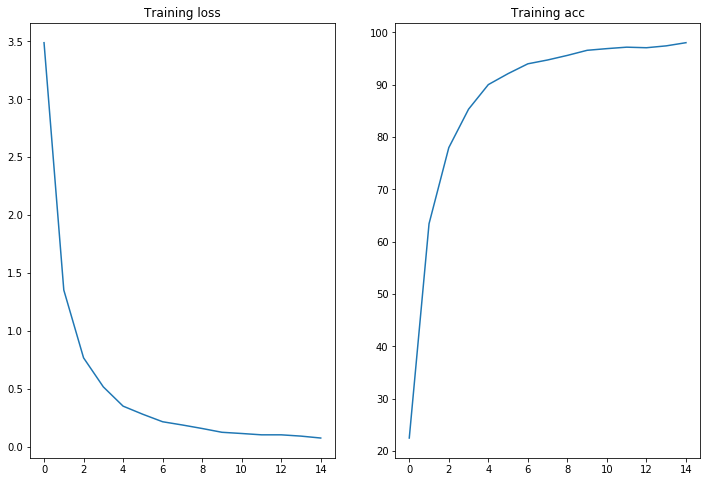

In [15]:
# plot the stats
f, axarr = plt.subplots(1, 2, figsize = (12, 8))
axarr[0].plot(training_losses)
axarr[0].set_title("Training loss")
axarr[1].plot(training_accs)
axarr[1].set_title("Training acc")

## Predict test set

In [8]:
model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                             transforms.ToTensor(),
                             transforms.Normalize((0.5,), (0.5,))])

# open csv file
csvFile = open('res101.csv', 'w', encoding='utf8', newline='')
writer = csv.writer(csvFile)
writer.writerow(['id', 'label'])
img_test = os.listdir(test_folder_path)

# predict test set and write in csv file
for i in range(len(img_test)):
    image = Image.open(os.path.join(test_folder_path, img_test[i]))
    image = image.convert('RGB')
    image = loader(image).float()
    image = torch.autograd.Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    image = image.cuda()
    output = model_ft(image)
    conf, predicted = torch.max(output.data, 1)
    index = (targets == predicted.item()).nonzero()
    writer.writerow([img_test[i].split('.')[0], lbls[index[0][0]]])
csvFile.close()

/home/wayne/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
